### Demo SURE-CNN for HSI denoising
- Simulated data are created (using Matlab) and stored in folder **hsi_data**
- A matlab file (e.g. sigma50eta0dc.mat) has: img--> clean image, img_noisy --> noisy image; sigma2 --> estimated sigma by Wavelet

In [1]:
import tensorflow as tf
import numpy as np

from models.skipnet import *
from utils.common import *
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import os
import scipy.io as sio
os.environ["CUDA_VISIBLE_DEVICES"]="0"

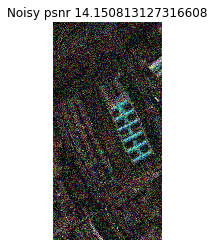

In [2]:
dname="sigma50eta0PaviaU"
fname="hsi_data/Demo/"+dname+".mat"
data = sio.loadmat(fname)
img_clean_np = data["image"].astype(np.float32)
img_noisy_np = data["image_noisy"].astype(np.float32)
sigmaest = data["sigma2"].astype(np.float32) #estimated sigma by Wavelet (sigma2) or HySime (sigma1)
# sigma=data['noiselev'].astype(np.float32) #True sigma (but unknow in practice)

showband=[57,27,17]
plt.imshow(np.clip(img_noisy_np[:,:,showband],0,1))
# plt.imshow(img_clean_crop[:,:,showband])
plt.title("Noisy psnr "+str(psnr(img_clean_np,img_noisy_np)))
plt.axis("off")
plt.show()

img_noisy=img_noisy_np.reshape(1,img_noisy_np.shape[0],img_noisy_np.shape[1],img_noisy_np.shape[2])
img_clean=img_clean_np.reshape(1,img_clean_np.shape[0],img_clean_np.shape[1],img_clean_np.shape[2])

Save model in *__filepath__*

In [3]:
sure=True
if sure:
    filepath= "./results/best model/Demo/"+"sure"+dname+".hdf5"
else:
    filepath= "./results/best model/Demo/"+"dip"+dname+".hdf5"

In [4]:
print(filepath)

./results/best model/Demo/suresigma50eta0PaviaU.hdf5


In [5]:
#Define model
mymodel=skip(ndown=5,channel=img_noisy.shape[-1])
lr = 0.001
myoptimizer = tf.keras.optimizers.Adam(lr)
num_epochs = 801
loss_object=tf.keras.losses.MeanSquaredError()

In [6]:
# Calculate gradient
@tf.function
def grad(model,inputs,targets):
    with tf.GradientTape() as tape:
        loss_value,div_value=losshyper(model,inputs,targets,sigma=sigmaest,sure=sure)
    return loss_value, div_value, tape.gradient(loss_value,model.trainable_variables)

Training and save only best model (interm of PSNR)
- train_loss_results: Training loss which is expected closed to true_mse
- true_mse: MSE between denoised image and reference image
- train_div_results: divergence term in SURE formula

In [7]:
train_loss_results = []
train_div_results = []
# true_mse = []
denoised_psnr=[]
curr_psnr=0
for epoch in range(num_epochs):
    if sure:
        loss_label="SURE"
        loss_value, div_value, grads = grad(mymodel, img_noisy, img_noisy)
        myoptimizer.apply_gradients(zip(grads, mymodel.trainable_variables))
        img_out = mymodel.predict(img_noisy)
        if psnr(img_clean_np,img_out[0])>curr_psnr:
            tf.keras.models.save_model(mymodel,filepath)
            curr_psnr=psnr(img_clean_np,img_out[0])
    else:
        loss_label="DIP"
        img_noisy1=img_noisy +tf.random.normal((tf.shape(img_noisy)),0.0,1/30.0)
        loss_value, div_value, grads = grad(mymodel, img_noisy1, img_noisy)
        myoptimizer.apply_gradients(zip(grads, mymodel.trainable_variables))
        img_out = mymodel.predict(img_noisy1)
        if psnr(img_clean_np,img_out[0])>curr_psnr:
            tf.keras.models.save_model(mymodel,filepath)
            curr_psnr=psnr(img_clean_np,img_out[0])
    
#     true_mse.append(loss_object(img_clean,img_out).numpy())
    train_loss_results.append(loss_value)
    train_div_results.append(div_value)
    denoised_psnr.append(psnr(img_clean_np,img_out[0]))
    
#     print('Iteration %05d    Loss %f       True MSE %f     PSNR %f' % (epoch, loss_value, loss_object(img_clean,img_out).numpy()
#                                                                        ,psnr(img_clean_np,img_out[0])), '\r', end='')
    print('Iteration %05d    Loss %f     PSNR %f' % (epoch, loss_value, psnr(img_clean_np,img_out[0])), '\r', end='')
    
#     if epoch % 100 == 0:
#         plt.subplot(131)
#         plt.imshow(np.clip(img_noisy_np[:,:,showband],0,1))
#         plt.title("noisy img")
#         plt.subplot(132)
#         plt.imshow(img_out[0][:,:,showband])
#         plt.title("denoised img")
#         plt.subplot(133)
#         plt.imshow(img_clean_np[:,:,showband])
#         plt.title("clean img")
#         plt.show()

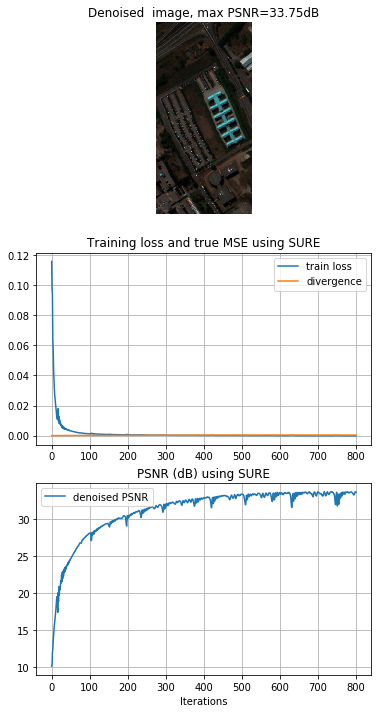

In [8]:
fig1, (ax,ax1, ax2) = plt.subplots(3,sharex=False,figsize=(6,12))
ax.imshow(np.clip(img_out[0][:,:,showband],0,1))
ax.set_title("Denoised  image, max PSNR="+str(np.round(np.max(denoised_psnr),2))+"dB")
ax.axis("off")
# ax1.plot(range(num_epochs),true_mse,label="true mse")
ax1.plot(range(num_epochs),train_loss_results, label ="train loss")
ax1.plot(range(num_epochs),train_div_results,label="divergence")
ax1.set_title("Training loss and true MSE using "+loss_label)
ax1.legend()
ax1.grid()

ax2.plot(denoised_psnr,label="denoised PSNR")
ax2.set_xlabel('Iterations')
ax2.set_title("PSNR (dB) using "+loss_label)
ax2.legend()
ax2.grid()
# fig1.savefig(loss_label+"sigma"+siglbl+str(np.mean(sigma_true*255))+".png")

In [9]:
PUbestmodel=tf.keras.models.load_model(filepath)
out_best=PUbestmodel.predict(img_noisy)

In [10]:
def meanssim(X,Y):
    bandssim=[]
    for i in range(X.shape[2]):
        bandssim.append(ssim(X[:,:,i],Y[:,:,i],data_range=1.,K1=0.01,K2=0.03
                             ,gaussian_weights=True,sigma=1.5,use_sample_covariance=False))
    return np.mean(bandssim)

In [11]:
print(psnr(img_clean_np,out_best[0]))
print(meanssim(img_clean_np,out_best[0]))

33.745942109188164
0.9113628176510163


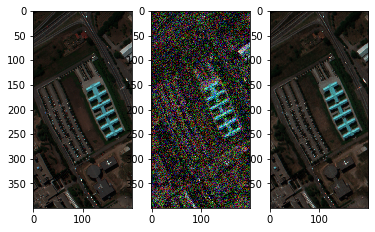

In [20]:
plt.subplot(131)
plt.imshow(img_clean_np[:,:,showband])
plt.subplot(132)
plt.imshow(np.clip(img_noisy_np[:,:,showband],0,1))
plt.subplot(133)
plt.imshow(out_best[0][:,:,showband])
plt.show()

In [12]:
# sio.savemat("./results/DL_Compare/"+dname+".mat",mdict={"xsure":out_best[0],"xnoise":img_noisy_np,"x":img_clean_np})

In [13]:
# np.save("sureloss100",train_loss_results)
# np.save("suretrue100",true_mse)

In [14]:
# sureloss=np.load("sureloss100.npy")
# suretrue=np.load("suretrue100.npy")
# mseloss=np.load("mseloss100.npy")
# msetrue=np.load("msetrue100.npy")

In [15]:
# fig10=plt.figure(figsize=(6,5))
# plt.plot(sureloss,"r--", label= "SURE loss",linewidth=2.0)
# plt.plot(suretrue,"g-.", label= "SURE true MSE",linewidth=2.0)
# plt.plot(mseloss, "k", label= "fidelity loss",linewidth=2.0)
# plt.plot(msetrue, "b",label= "fidelity true MSE",linewidth=2.0)
# # plt.ylim(ymin=-0.01,ymax=0.20)
# plt.xlabel("Iteration")
# plt.ylabel("Loss")
# plt.legend()
# plt.grid()
# plt.show()
# # fig10.savefig("loss.pdf")